# Features in ΛCDM vs w0waCDM

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import baccoemu
from tqdm import tqdm

sys.path.insert(0, str(Path.cwd().parent))
from DUMP.data.features_engineering import make_features
from DUMP.utils import find_solver_grid
from DUMP.data.constants import bacco_target_z, solver_dz

## 1. Load and Group Data

In [55]:
# Load test set
df = pd.read_csv("../data/cosmologies_test.csv")

# Create w0-wa bins
w0_bins = np.linspace(-1.15, -0.85, 4)
wa_bins = np.linspace(-0.3, 0.3, 4)

df['w0_group'] = pd.cut(df['w0'], bins=w0_bins, labels=['w0_low', 'w0_mid', 'w0_high'])
df['wa_group'] = pd.cut(df['wa'], bins=wa_bins, labels=['wa_low', 'wa_mid', 'wa_high'])
df['group'] = df['w0_group'].astype(str) + '_' + df['wa_group'].astype(str)

print(f"Total cosmologies: {len(df)}")
print(f"\nCosmologies per group:")
print(df.groupby('group').size())

Total cosmologies: 100000

Cosmologies per group:
group
w0_high_wa_high    11029
w0_high_wa_low     11140
w0_high_wa_mid     11164
w0_low_wa_high     11110
w0_low_wa_low      11199
w0_low_wa_mid      11024
w0_mid_wa_high     11195
w0_mid_wa_low      10994
w0_mid_wa_mid      11145
dtype: int64


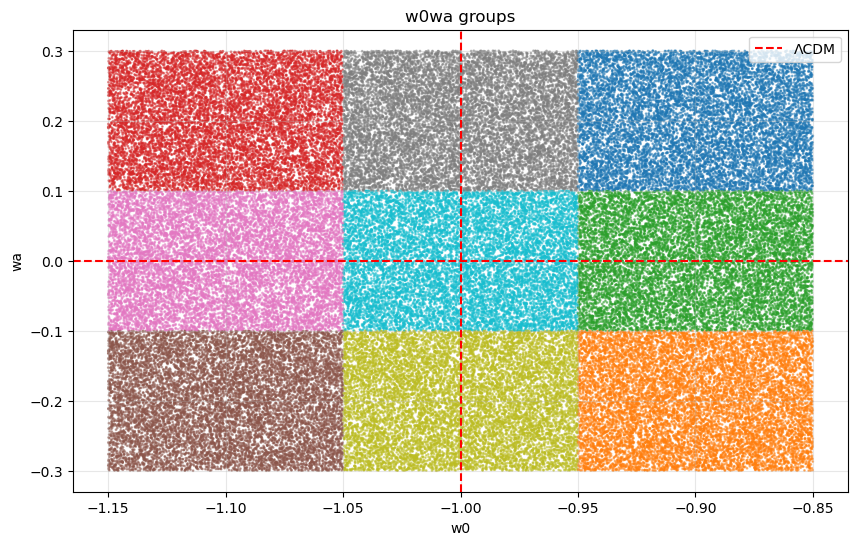

In [56]:
# Visualize w0-wa distribution
plt.figure(figsize=(10, 6))
plt.scatter(df['w0'], df['wa'], c=df['group'].astype('category').cat.codes, 
            cmap='tab10', s=1, alpha=0.5)
plt.axvline(-1.0, color='red', linestyle='--', label='ΛCDM')
plt.axhline(0.0, color='red', linestyle='--')
plt.xlabel('w0')
plt.ylabel('wa')
plt.title('w0wa groups')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 2. Select Group and Load Train Set

**Configure which test group to compare against train set:**

In [59]:
# SELECT TEST GROUP TO COMPARE AGAINST TRAIN SET
# Available groups from the data:
# 'w0_low_wa_low', 'w0_low_wa_mid', 'w0_low_wa_high',
# 'w0_mid_wa_low', 'w0_mid_wa_mid', 'w0_mid_wa_high',
# 'w0_high_wa_low', 'w0_high_wa_mid', 'w0_high_wa_high'

TEST_GROUP = 'w0_high_wa_low'  # Central group to analyze

# Verify group exists
available_groups = df['group'].unique()
assert TEST_GROUP in available_groups, f"{TEST_GROUP} not found in data"

print(f"Test group to analyze: {TEST_GROUP}")
print(f"\nTest group statistics:")
print(df[df['group'] == TEST_GROUP][['w0', 'wa']].describe())

# Load train set
df_train = pd.read_csv("../data/cosmologies_train.csv")
print(f"\nTrain set cosmologies: {len(df_train)}")

Test group to analyze: w0_high_wa_low

Test group statistics:
                 w0            wa
count  11140.000000  11140.000000
mean      -0.900191     -0.200562
std        0.028677      0.057931
min       -0.949989     -0.299998
25%       -0.924991     -0.251113
50%       -0.900533     -0.200520
75%       -0.875464     -0.150170
max       -0.850006     -0.100002

Train set cosmologies: 180000


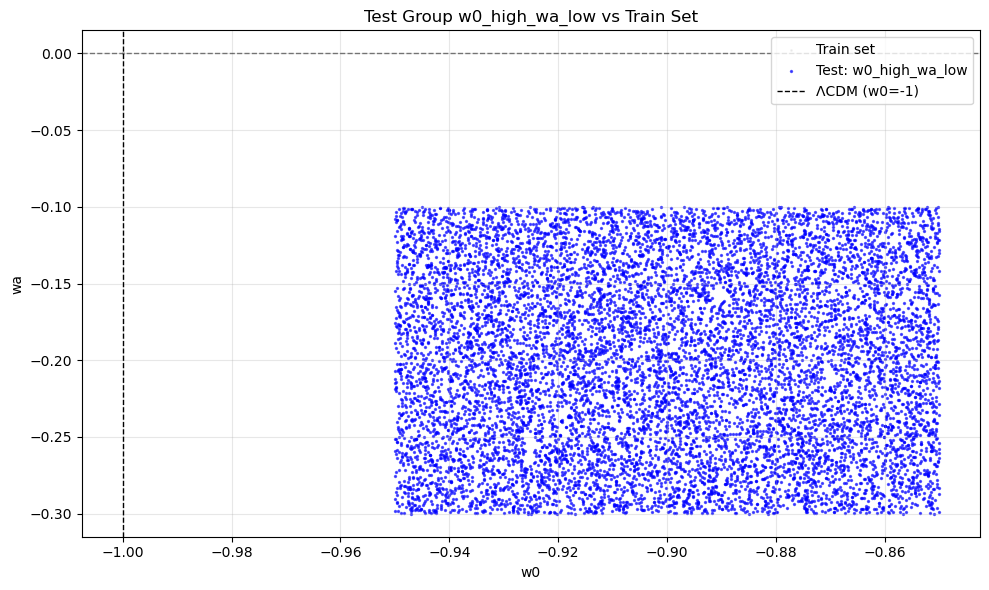

In [60]:
# Visualize test group and train set in w0-wa space
plt.figure(figsize=(10, 6))

# Plot train set in gray
plt.scatter(df_train['w0'], df_train['wa'], c='lightgray', s=1, alpha=0.3, label='Train set')

# Highlight selected test group
group_data = df[df['group'] == TEST_GROUP]
plt.scatter(group_data['w0'], group_data['wa'], 
            c='blue', s=2, alpha=0.6, label=f'Test: {TEST_GROUP}')

plt.axvline(-1.0, color='black', linestyle='--', linewidth=1, label='ΛCDM (w0=-1)')
plt.axhline(0.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('w0')
plt.ylabel('wa')
plt.title(f'Test Group {TEST_GROUP} vs Train Set')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [69]:
# Sample cosmologies: test group + train set
n_per_group = 1000

# Sample from test group
test_sampled = df[df['group'] == TEST_GROUP].sample(n=n_per_group, random_state=42)
test_sampled = test_sampled.copy()
test_sampled['source'] = 'test'

# Sample from train set
train_sampled = df_train.sample(n=n_per_group, random_state=42)
train_sampled = train_sampled.copy()
train_sampled['source'] = 'train'

# Combine
sampled = pd.concat([test_sampled, train_sampled], ignore_index=True)

print(f"Sampled {len(sampled)} cosmologies:")
print(f"  Test group ({TEST_GROUP}): {len(test_sampled)}")
print(f"  Train set: {len(train_sampled)}")

Sampled 2000 cosmologies:
  Test group (w0_high_wa_low): 1000
  Train set: 1000


In [70]:
# Setup
solver_z = find_solver_grid(bacco_target_z, solver_dz)
emulator = baccoemu.Matter_powerspectrum()
features_list = ["H", "dH_dz", "logrhom", "dlogrhom_dz", "D", "dD_dz", "lin_pk"]

print(f"Computing {len(features_list)} features for {len(sampled)} cosmologies...")

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator Arico et al. (2021)...
Baryonic Emulator Arico et al. (2025) loaded in memory.
Computing 7 features for 2000 cosmologies...


In [71]:
# Compute features
results = {'test': [], 'train': []}

for i, (idx, row) in tqdm(enumerate(sampled.iterrows()), total=len(sampled)):
    
    cosmo = row[['omega_cold', 'omega_baryon', 'hubble', 'w0', 'wa', 'sigma8_cold', 'ns']].to_dict()
    source = row['source']
    
    features = make_features(emulator, features_list, cosmo, solver_z)
    results[source].append(features)

print(f"Done! Computed features for test and train sets")

100%|██████████| 2000/2000 [00:52<00:00, 38.13it/s]

Done! Computed features for test and train sets


## 3. Aggregate and Plot

In [72]:
# Aggregate features per source (test vs train)
agg = {}
for source, feature_list in results.items():
    agg[source] = {}
    for feat_name in features_list:
        stacked = np.stack([f[feat_name] for f in feature_list])
        agg[source][feat_name] = {
            'mean': np.mean(stacked, axis=0),
            'std': np.std(stacked, axis=0)
        }

print(f"Aggregated test and train sets")

Aggregated test and train sets


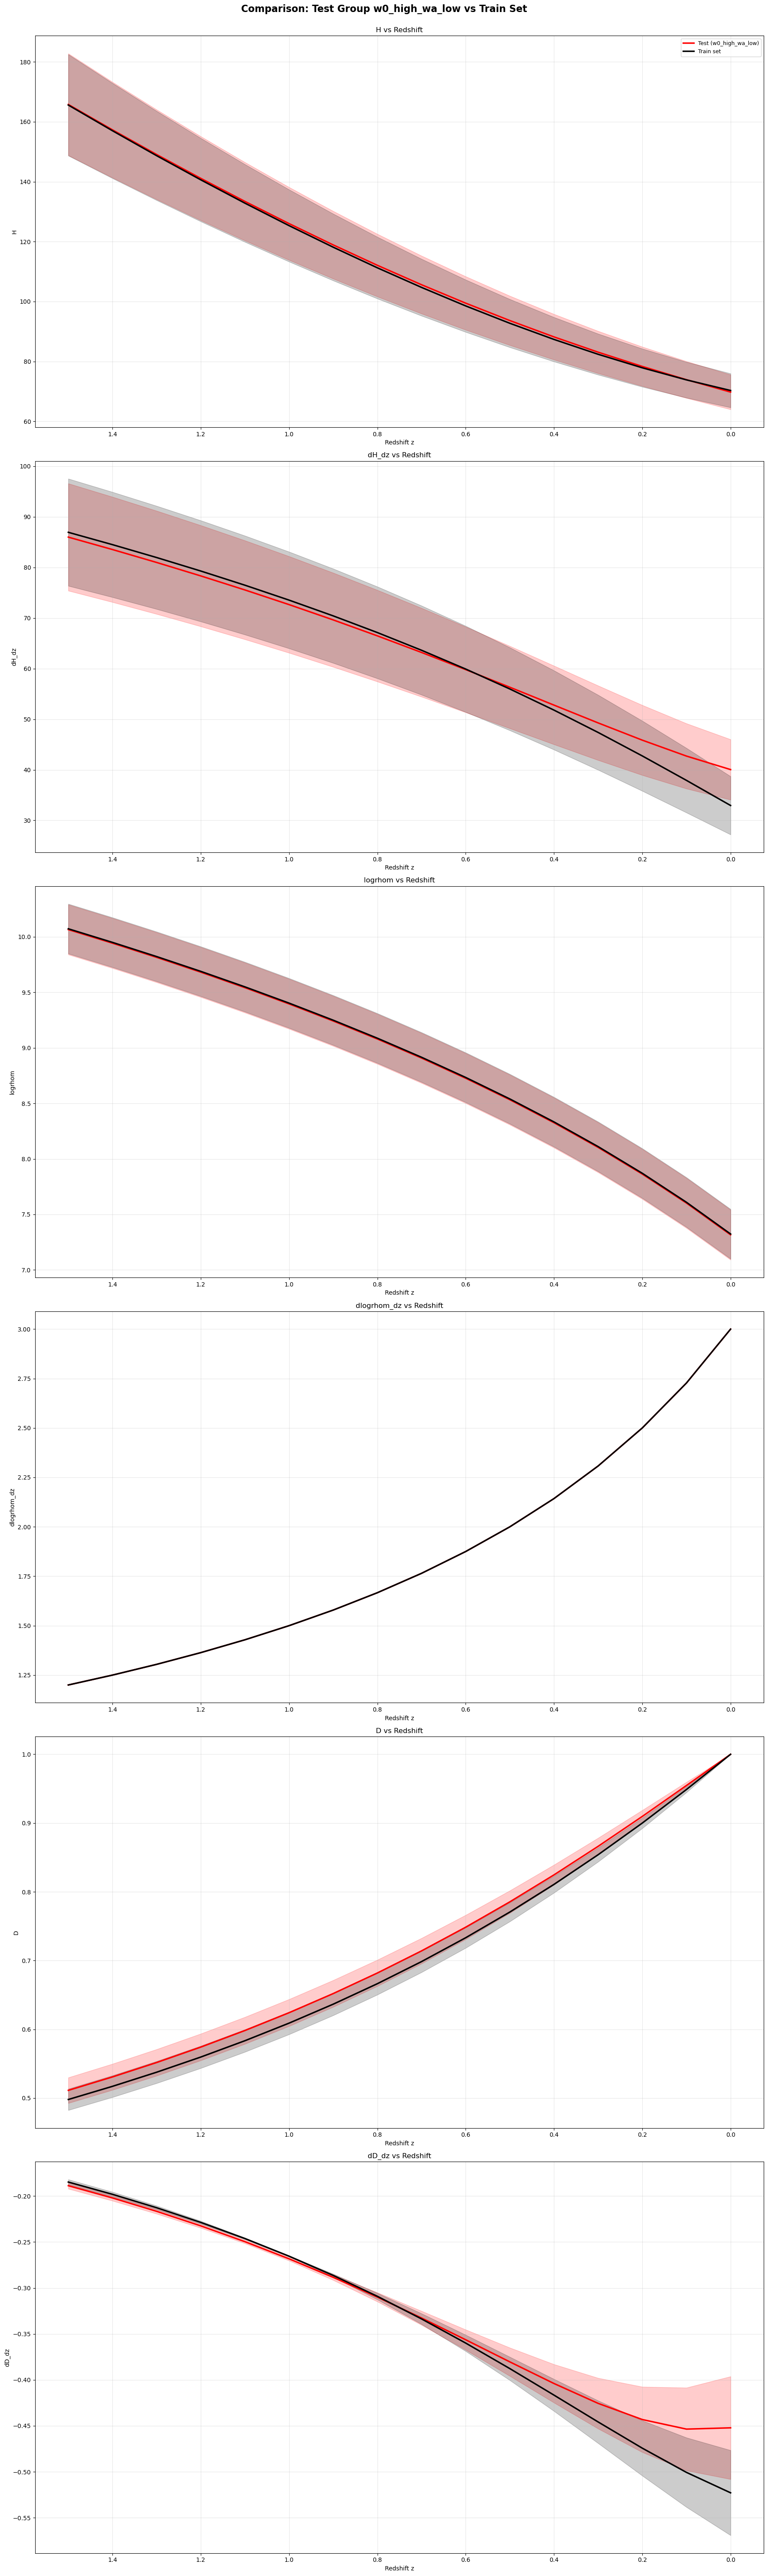

In [75]:
# Plot all features comparing test group vs train set (excluding lin_pk)
features_to_plot = [f for f in features_list if f != 'lin_pk']

fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, figsize=(18, 10*len(features_to_plot)))
if len(features_to_plot) == 1:
    axes = [axes]

# Use distinct colors
colors_dict = {'test': 'red', 'train': 'black'}

for idx, feat_name in enumerate(features_to_plot):
    ax = axes[idx]
    
    for source in ['test', 'train']:
        data = agg[source]
        mean = data[feat_name]['mean']
        std = data[feat_name]['std']
        
        # Downsample to target_z for cleaner plots
        z_indices = [np.argmin(np.abs(solver_z - z)) for z in bacco_target_z]
        z_plot = bacco_target_z
        
        mean_plot = mean[z_indices]
        std_plot = std[z_indices]
        
        label = f'{source.capitalize()}' + (f' ({TEST_GROUP})' if source == 'test' else ' set')
        
        ax.plot(z_plot, mean_plot, label=label, color=colors_dict[source], linewidth=2.5)
        ax.fill_between(z_plot, mean_plot - std_plot, mean_plot + std_plot, 
                       color=colors_dict[source], alpha=0.2)
    
    ax.set_xlabel('Redshift z')
    ax.set_ylabel(feat_name)
    ax.set_title(f'{feat_name} vs Redshift')
    ax.invert_xaxis()
    ax.grid(alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=9)

plt.suptitle(f'Comparison: Test Group {TEST_GROUP} vs Train Set', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 4. Linear Power Spectrum - Separate Plots per k-bin

Linear pk shape: 451 redshifts × 30 k-bins


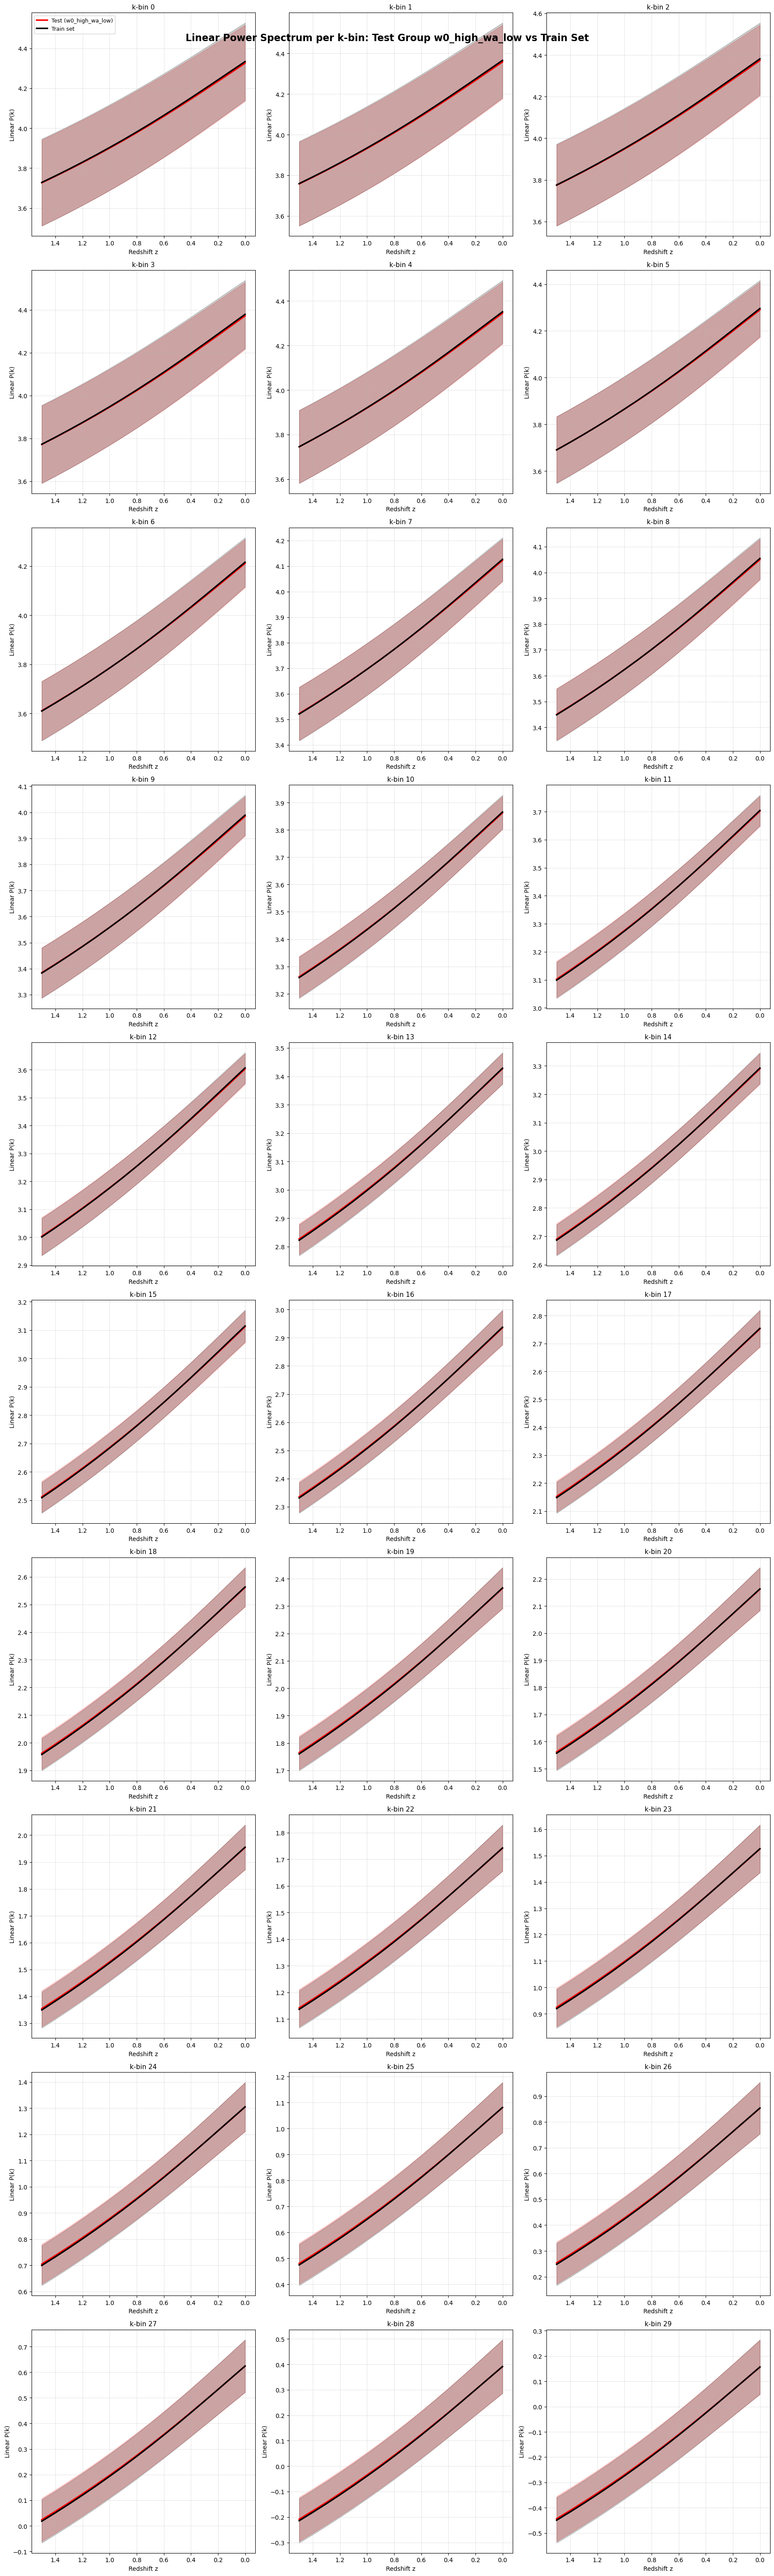

In [76]:
# Plot linear pk separately for each k-bin
colors_dict = {'test': 'red', 'train': 'black'}

# Get the shape of lin_pk to determine number of k-bins
lin_pk_shape = agg['test']['lin_pk']['mean'].shape
n_z, n_k = lin_pk_shape
print(f"Linear pk shape: {n_z} redshifts × {n_k} k-bins")

# Create a subplot for each k-bin
n_cols = 3
n_rows = int(np.ceil(n_k / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten()

z_indices = [np.argmin(np.abs(solver_z - z)) for z in bacco_target_z]
z_plot = bacco_target_z

for k_idx in range(n_k):
    ax = axes[k_idx]
    
    for source in ['test', 'train']:
        data = agg[source]
        mean = data['lin_pk']['mean']
        std = data['lin_pk']['std']
        
        # Extract data for this k-bin
        mean_plot = mean[z_indices, k_idx]
        std_plot = std[z_indices, k_idx]
        
        label = f'{source.capitalize()}' + (f' ({TEST_GROUP})' if source == 'test' else ' set')
        
        ax.plot(z_plot, mean_plot, label=label, color=colors_dict[source], linewidth=2.5)
        ax.fill_between(z_plot, mean_plot - std_plot, mean_plot + std_plot,
                       color=colors_dict[source], alpha=0.2)
    
    ax.set_xlabel('Redshift z', fontsize=10)
    ax.set_ylabel('Linear P(k)', fontsize=10)
    ax.set_title(f'k-bin {k_idx}', fontsize=11)
    ax.invert_xaxis()
    ax.grid(alpha=0.3)
    if k_idx == 0:
        ax.legend(fontsize=9)

# Hide unused subplots
for k_idx in range(n_k, len(axes)):
    axes[k_idx].set_visible(False)

plt.suptitle(f'Linear Power Spectrum per k-bin: Test Group {TEST_GROUP} vs Train Set', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()